# LKJ Cholesky Covariance Priors for Multivariate Normal Models

While the [inverse-Wishart distribution](https://en.wikipedia.org/wiki/Inverse-Wishart_distribution) is the conjugate prior for the covariance matrix of a multivariate normal distribution, it is [not very well-suited](https://github.com/pymc-devs/pymc3/issues/538#issuecomment-94153586) to modern Bayesian computational methods.  For this reason, the [LKJ prior](http://www.sciencedirect.com/science/article/pii/S0047259X09000876) is recommended when modeling the covariance matrix of a multivariate normal distribution.

To illustrate modelling covariance with the LKJ distribution, we first generate a two-dimensional normally-distributed sample data set.

In [1]:
%matplotlib inline

In [2]:
from warnings import filterwarnings

In [3]:
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

In [4]:
filterwarnings('ignore', message='findfont')

In [5]:
SEED = 3264602 # from random.org

np.random.seed(SEED)

In [6]:
N = 10000

μ_actual = np.array([1, -2])
Σ_actual = np.array([[0.5, -0.3],
                     [-0.3, 1.]])

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)

In [7]:
var, U = np.linalg.eig(Σ_actual)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

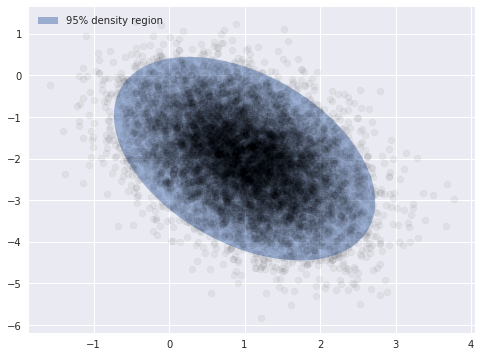

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.05, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect], ['95% density region'], loc=2);

The sampling distribution for the multivariate normal model is $\mathbf{x} \sim N(\mu, \Sigma)$, where $\Sigma$ is the covariance matrix of the sampling distribution, with $\Sigma_{ij} = \textrm{Cov}(x_i, x_j)$.  The density of this distribution is

$$f(\mathbf{x}\ |\ \mu, \Sigma^{-1}) = (2 \pi)^{-\frac{k}{2}} |\Sigma|^{-\frac{1}{2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)\right).$$

The LKJ distribution provides a prior on the correlation matrix, $\mathbf{C} = \textrm{Corr}(x_i, x_j)$, which, combined with priors on the standard deviations of each component, [induces](http://www3.stat.sinica.edu.tw/statistica/oldpdf/A10n416.pdf) a prior on the covariance matrix, $\Sigma$.  Since inverting $\Sigma$ is numerically unstable and inefficient, it is computationally advantageous to use the [Cholesky decompositon](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\Sigma$, $\Sigma = \mathbf{L} \mathbf{L}^{\top}$, where $\mathbf{L}$ is a lower-triangular matrix.  This decompositon allows computation of the term $(\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)$ using back-substitution, which is more numerically stable and efficient than direct matrix inversion.

PyMC3 supports LKJ priors for the Cholesky decomposition of the covariance matrix via the [LKJCholeskyCov](../api/distributions/multivariate.rst) distribution.  This distribution has parameters `n` and `sd_dist`, which are the dimension of the observations, $\mathbf{x}$, and the PyMC3 distribution of the component standard deviations, repsectively.  It also has a hyperparamter `eta`, which controls the amount of correlation between components of $\mathbf{x}$.  The LKJ distribution has the density $f(\mathbf{C}\ |\ \eta) \propto |\mathbf{C}|^{\eta - 1}$, so $\eta = 1$ leads to a uniform distribution on correlation matrices, while the magnitude of correlations between components decreases as $\eta \to \infty$.

In this example, we model the standard deviations with $\textrm{HalfCauchy}(2.5)$ priors, and the correlation matrix as $\mathbf{C} \sim \textrm{LKJ}(\eta = 2)$.

In [9]:
with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))

Since the Cholesky decompositon of $\Sigma$ is lower triangular, `LKJCholeskyCov` only stores the diagonal and sub-diagonal entries, for efficiency.

In [10]:
packed_L.tag.test_value.shape

(3,)

We use [expand_packed_triangular](../api/math.rst) to transform this vector into the lower triangular matrix $\mathbf{L}$, which appears in the Cholesky decomposition $\Sigma = \mathbf{L} \mathbf{L}^{\top}$.

In [11]:
with model:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))

In [12]:
L.tag.test_value.shape

(2, 2)

To complete our model specification, we place independent, vague normal priors, $\mu_i \sim N(0, 10^2),$ on the components of $\mu$.

In [13]:
with model:
    μ = pm.Normal('μ', 0., 10., shape=2,
                  testval=x.mean(axis=0))
    obs = pm.MvNormal('obs', μ, chol=L, observed=x)

We sample from this model using NUTS.

In [14]:
with model:
    trace = pm.sample(random_seed=SEED, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 24,314:   6%|▋         | 12779/200000 [00:13<02:59, 1045.84it/s]
Convergence archived at 12800
Interrupted at 12,800 [6%]: Average Loss = 30,353
100%|██████████| 1000/1000 [00:15<00:00, 65.87it/s]


Both the traces and Gelman-Rubin statistics indicate excellent convergence.

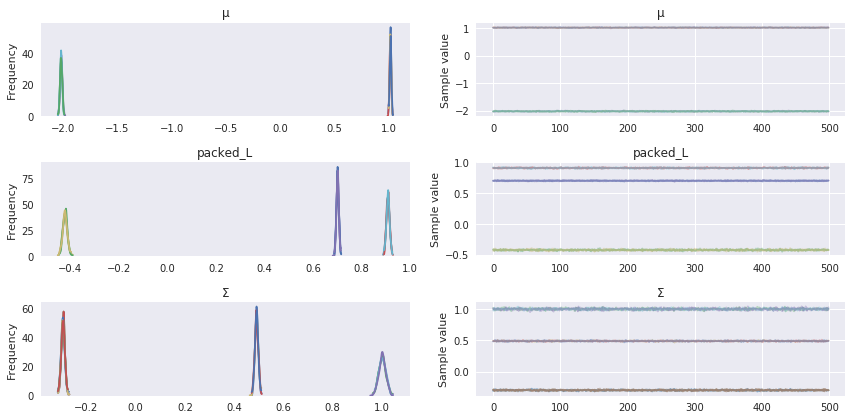

In [15]:
pm.traceplot(trace);

In [16]:
max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

1.0041914870298023

We see that the posterior expected value of the each component of $\mu$ and $\Sigma$ is within 2% of the true value.

In [17]:
μ_post = trace['μ'].mean(axis=0)
1 - μ_post / μ_actual

array([-0.0183651 , -0.00919685])

In [18]:
Σ_post = trace['Σ'].mean(axis=0)
1 - Σ_post / Σ_actual

array([[ 0.0172408 ,  0.01600426],
       [ 0.01600426, -0.00240787]])

The following plot also shows excellent visual agreement between the true distribution and the posterior distribution.

In [19]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180. / np.pi * np.arccos(np.abs(U_post[0, 0]))

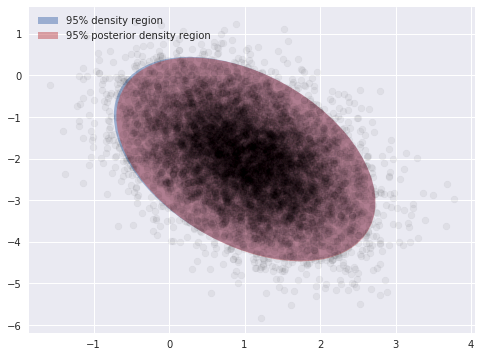

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

e_post = Ellipse(μ_post, 2 * np.sqrt(5.991 * var_post[0]),
                 2 * np.sqrt(5.991 * var_post[1]),
                 angle=angle_post)
e_post.set_alpha(0.5)
e_post.set_facecolor(red)
e_post.set_zorder(10);
ax.add_artist(e_post);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.05, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
rect_post = plt.Rectangle((0, 0), 1, 1, fc=red, alpha=0.5)
ax.legend([rect, rect_post],
          ['95% density region',
           '95% posterior density region'],
          loc=2);